In [1]:
# !pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 46.2 MB/s eta 0:00:00


In [2]:
from torch_geometric.datasets import QM9
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
from torch.nn import Linear, BatchNorm1d, Dropout, LayerNorm
from torch_geometric.utils import to_networkx
from torch_geometric.loader import DataLoader
import torch
from random import randint
from torch.nn import TransformerEncoderLayer, TransformerEncoder

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
device

device(type='cuda')

In [5]:
dataset = QM9(root="./dataset/")

Extracting dataset/raw/qm9_v3.zip
Processing...
Using a pre-processed version of the dataset. Please install 'rdkit' to alternatively process the raw data.
Done!


In [6]:
data = dataset.data
print(data)
print(dataset.num_features)
print(dataset.num_classes)
print(len(dataset))

Data(x=[2359210, 11], edge_index=[2, 4883516], edge_attr=[4883516, 4], y=[130831, 19], pos=[2359210, 3], idx=[130831], name=[130831], z=[2359210])
11
19
130831


/usr/local/lib/python3.10/dist-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


In [7]:
# dataset.print_summary()
target = 6 # Setting zero point vibrational energy as the target variable.
dataset.data.y = dataset.data.y[:, target]
dataset.data.y = (dataset.data.y - dataset.data.y.mean()) / dataset.data.y.std()
# dataset.x = (dataset.x - dataset.x.mean(dim=0)) / dataset.x.std(dim=0)

/usr/local/lib/python3.10/dist-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. The data of the dataset is already cached, so any modifications to `data` will not be reflected when accessing its elements. Clearing the cache now by removing all elements in `dataset._data_list`. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


In [8]:
dataset.x[0]

tensor([0., 1., 0., 0., 0., 6., 0., 0., 0., 0., 4.])

In [9]:
dataset.y[0]

tensor(-3.1487)

In [10]:
dataset.num_classes

/usr/local/lib/python3.10/dist-packages/torch_geometric/data/dataset.py:169: UserWarning: Found floating-point labels while calling `dataset.num_classes`. Returning the number of unique elements. Please make sure that this is expected before proceeding.
  warnings.warn("Found floating-point labels while calling "


72452

In [11]:
def plot_graph(graph_data):
    graph = to_networkx(graph_data, to_undirected=True)

    def visualize_graph(G):
        plt.figure(figsize=(7,7))
        nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=True)
        plt.show()

    visualize_graph(graph)

torch.Size([23, 11])
torch.Size([1])


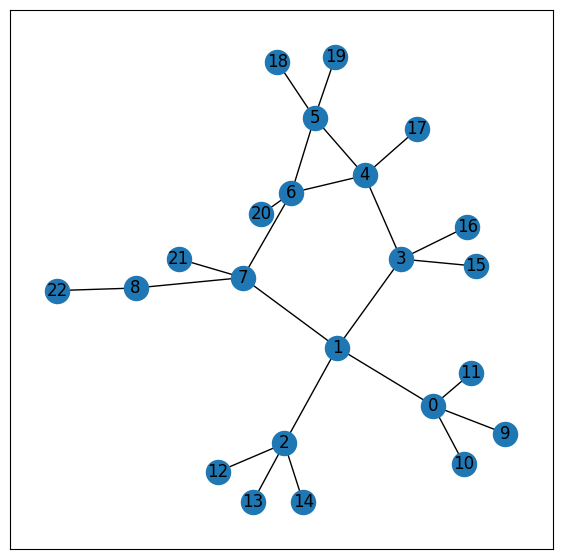

torch.Size([16, 11])
torch.Size([1])


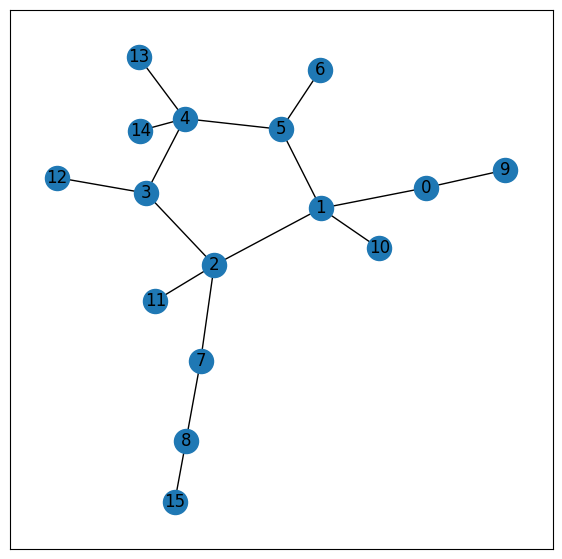

torch.Size([16, 11])
torch.Size([1])


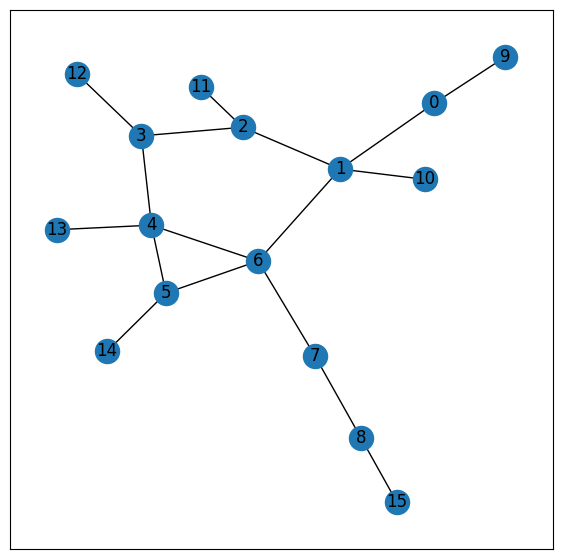

torch.Size([21, 11])
torch.Size([1])


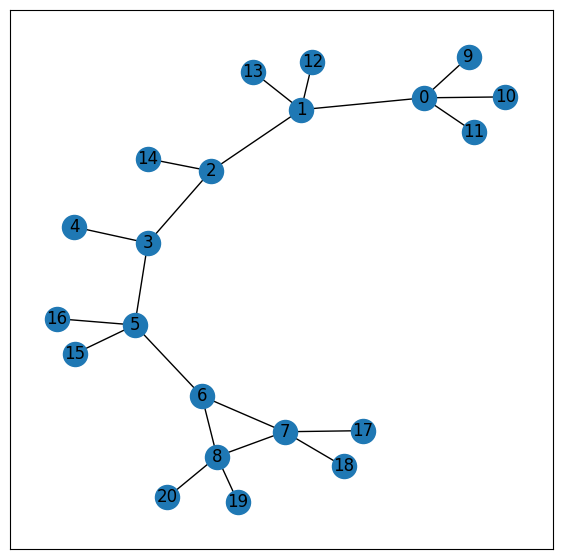

torch.Size([19, 11])
torch.Size([1])


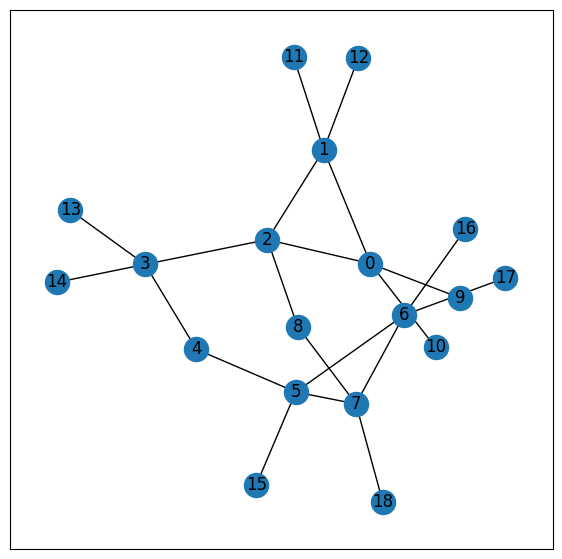

In [12]:
for _ in range(0, 5):
    idx = randint(0, len(dataset) - 1)
    data = dataset[idx]
    print(data.x.shape)
    print(data.y.shape)
    plot_graph(data)

In [13]:
class GCN(torch.nn.Module):
    def __init__(self, num_node_features, hidden_dim=128, num_heads=4):
        super().__init__()

        self.gnn1 = GCNConv(num_node_features, hidden_dim)
        self.gnn2 = GCNConv(hidden_dim, hidden_dim)

        encoder_layer = TransformerEncoderLayer(
            d_model=hidden_dim,
            nhead=num_heads,
            dim_feedforward=hidden_dim*4,
            batch_first=True
        )
        self.transformer = TransformerEncoder(encoder_layer, num_layers=3)

        self.linear1 = Linear(hidden_dim, hidden_dim)
        self.linear2 = Linear(hidden_dim, 1)

        self.norm1 = LayerNorm(hidden_dim)
        self.norm2 = LayerNorm(hidden_dim)
        self.dropout = Dropout(0.2)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        x = self.gnn1(x, edge_index)
        x = F.relu(x)
        x = self.norm1(x)
        x = self.dropout(x)

        x = self.gnn2(x, edge_index)
        x = F.relu(x)
        x = self.norm2(x)
        x = self.dropout(x)

        max_nodes = max(torch.bincount(batch))
        batch_size = batch[-1].item() + 1

        x_padded = torch.zeros(batch_size, max_nodes, x.size(-1), device=x.device)
        for i in range(batch_size):
            batch_mask = (batch == i)
            x_padded[i, :batch_mask.sum()] = x[batch_mask]

        x = self.transformer(x_padded)

        x = x.mean(dim=1)

        x = self.linear1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.linear2(x)

        return x

In [14]:
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))

train_dataset = dataset[:train_size]
val_dataset = dataset[train_size:train_size+val_size]
test_dataset = dataset[train_size+val_size:]

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

In [15]:
train_losses = []
val_losses = []
test_losses = []

In [16]:
def plot_losses():
    plt.plot(train_losses, label="Training Loss")
    plt.plot(val_losses, label="Validation Loss")
    # plt.plot(test_losses, label="Testing Loss")
    plt.legend()
    plt.show()

In [17]:
@torch.no_grad()
def validate(model, criterion, scheduler):
    gcn.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            batch = batch.to(device)
            out = model(batch)
            val_loss += criterion(out.squeeze(), batch.y).item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    scheduler.step(val_loss)

    return val_loss / len(val_loader)

In [18]:
def train(model, optimizer, criterion, scheduler, epoch):
    gcn.train()
    total_loss = 0
    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()

        out = gcn(batch)
        loss = criterion(out.squeeze(), batch.y)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(gcn.parameters(), max_norm=1.0)
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    test_losses.append(avg_loss)
    val_loss = validate(model, criterion, scheduler)

    print(f'Epoch {epoch}: Train Loss: {avg_loss:.4f}, Val Loss: {val_loss:.4f}')

    return avg_loss, val_loss

In [19]:
@torch.no_grad()
def test(model, criterion):
    model.eval()
    total_loss = 0
    for batch in test_loader:
        batch = batch.to(device)
        prediction = model(batch)
        loss = criterion(prediction, batch.y)
        total_loss += loss.item()

    print(f"Test Loss: {total_loss / len(test_loader)}")

In [20]:
gcn = GCN(num_node_features=dataset.num_features, hidden_dim=128, num_heads=4).to(device)

In [21]:
optimizer = torch.optim.AdamW(gcn.parameters(), lr=0.001, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
criterion = torch.nn.MSELoss()

In [ ]:
for epoch in range(100):
    train(gcn, optimizer, criterion, scheduler, epoch)

test(gcn, criterion)

Epoch 0: Train Loss: 0.1164, Val Loss: 0.0002
Epoch 1: Train Loss: 0.0725, Val Loss: 0.0003
Epoch 2: Train Loss: 0.0623, Val Loss: 0.0003
Epoch 3: Train Loss: 0.0522, Val Loss: 0.0003
Epoch 4: Train Loss: 0.0487, Val Loss: 0.0002
Epoch 5: Train Loss: 0.0463, Val Loss: 0.0002
Epoch 6: Train Loss: 0.0453, Val Loss: 0.0001
Epoch 7: Train Loss: 0.0439, Val Loss: 0.0003
Epoch 8: Train Loss: 0.0437, Val Loss: 0.0001
Epoch 9: Train Loss: 0.0425, Val Loss: 0.0002
Epoch 10: Train Loss: 0.0419, Val Loss: 0.0001
Epoch 11: Train Loss: 0.0416, Val Loss: 0.0001
Epoch 12: Train Loss: 0.0416, Val Loss: 0.0001
Epoch 13: Train Loss: 0.0385, Val Loss: 0.0002
Epoch 14: Train Loss: 0.0385, Val Loss: 0.0001
Epoch 15: Train Loss: 0.0383, Val Loss: 0.0001
Epoch 16: Train Loss: 0.0374, Val Loss: 0.0002
Epoch 17: Train Loss: 0.0380, Val Loss: 0.0001
Epoch 18: Train Loss: 0.0372, Val Loss: 0.0002
Epoch 19: Train Loss: 0.0346, Val Loss: 0.0001
Epoch 20: Train Loss: 0.0329, Val Loss: 0.0001
Epoch 21: Train Loss: 0

In [ ]:
plot_losses()